Подготовка и проверка датасета

In [2]:
import pandas as pd
data = pd.read_csv('./intern_task.csv')
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB


In [9]:
missing_values = data.isnull().sum()
print(missing_values.sum())

0


Text(0.5, 1.0, 'Rank Histogram')

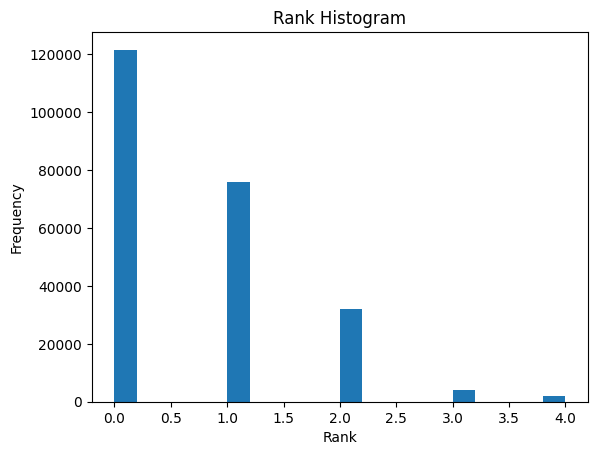

In [10]:
import matplotlib.pyplot as plt

plt.hist(data['rank'], bins=20)

plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank Histogram')

In [3]:
from sklearn.model_selection import train_test_split

sorted_data = data.sort_values(by='query_id')

qid = sorted_data['query_id']

feature = sorted_data.drop(columns=['rank'])

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# scaled_feature = scaler.fit_transform(feature)

target = sorted_data['rank']

feature_train, feature_test, target_train, target_test, qid_train, qid_test = train_test_split(feature, target, qid, test_size=0.2)


In [4]:
import numpy as np

_, group_train = np.unique(qid_train, return_counts=True)

Модель - LambdaRank

In [5]:
import lightgbm
from lightgbm import LGBMRanker

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

train_data = lightgbm.Dataset(feature_train, label=target_train, group=group_train)

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 13,
    'num_leaves': 100,
    'min_data_in_leaf': 50
}

num_round = 200
model = lightgbm.train(params, train_data, num_round)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.564597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26759
[LightGBM] [Info] Number of data points in the train set: 188206, number of used features: 141


Метрики@5: NCDG, MAP, ERR

In [6]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [7]:
qids = np.unique(qid_test)

In [8]:
ndcg_ = list()

for i, qid in enumerate(qids):
    y = target_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    p = model.predict(feature_test[qid_test == qid])

    idcg = ndcg(y, y, k=5)
    ndcg_.append(ndcg(p, y, k=5) / idcg)

In [9]:
np.mean(ndcg_)

0.5737116034289923

In [10]:
def precision(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order)
    relevant_docs = y_true_sorted[:k] > 0
    num_relevant_docs = np.sum(relevant_docs)
    precision = num_relevant_docs / k
    return precision

average_precisions = []

for i, qid in enumerate(qids):
    y = target_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    p = model.predict(feature_test[qid_test == qid])

    for k in range(1, 6):
        average_precisions.append(precision(p, y, k))

mean_average_precision = np.mean(average_precisions)


In [11]:
print(mean_average_precision)

0.694006843147848


In [40]:
def ERR(y_true, y_pred, k):
    order = np.argsort(y_pred)[::-1]

    y_true_sorted = np.take(y_true, order)

    p_k = (2 ** y_true_sorted.iloc[0] - 1) / (2 ** 4)

    p_i = [(2 ** y - 1)/ (2 ** 4) for y in y_true_sorted[:k-1]]

    ERR_score = 0.0
    for i in range(k):
        if i < k - 1:
            p = (1 - p_i[i])
        else:
            p = p_k
        ERR_score += p / (i + 1)

    return ERR_score

ERR_score = ERR(target_test, model.predict(feature_test), 5)
print(ERR_score)

0.5427083333333333
